# Creating a Surrogate Model
This tutorial covers the ['Peronne et al. (2018)' example](https://openml.github.io/openml-python/master/examples/40_paper/2018_neurips_perrone_example.html#sphx-glr-examples-40-paper-2018-neurips-perrone-example-py), but has minor modifications for the purpose of the tutorial.

This tutorial shows how to build a surrogate model based on OpenML data as done for *Scalable
Hyperparameter Transfer Learning* by Perrone et al..

> Scalable Hyperparameter Transfer Learning
> Valerio Perrone and Rodolphe Jenatton and Matthias Seeger and Cedric Archambeau
> In *Advances in Neural Information Processing Systems 31*, 2018
> Available at http://papers.nips.cc/paper/7917-scalable-hyperparameter-transfer-learning.pdf

In the following section, we shall do the following:

* Retrieve tasks and flows as used in the experiments by Perrone et al. (2018).
* Build a tabular data by fetching the evaluations uploaded to OpenML.
* Impute missing values and handle categorical data before building a Random Forest model that
  maps hyperparameter values to the area under curve score.

In [1]:
import openml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
flow_type = 'svm'

The subsequent functions are defined to fetch tasks, flows, evaluations and preprocess them into a tabular format that can be used to build models.

In [3]:
def fetch_evaluations(run_full=False,
                      flow_type='svm',
                      metric='area_under_roc_curve'):
    '''
    Fetch a list of evaluations based on the flows and tasks used in the experiments.

    Parameters
    ----------
    run_full : boolean
        If True, use the full list of tasks used in the paper
        If False, use 5 tasks with the smallest number of evaluations available
    flow_type : str, {'svm', 'xgboost'}
        To select whether svm or xgboost experiments are to be run
    metric : str
        The evaluation measure that is passed to openml.evaluations.list_evaluations

    Returns
    -------
    eval_df : dataframe
    task_ids : list
    flow_id : int
    '''
    # Collecting task IDs as used by the experiments from the paper
    if flow_type == 'svm' and run_full:
        task_ids = [
            10101, 145878, 146064, 14951, 34537, 3485, 3492, 3493, 3494,
            37, 3889, 3891, 3899, 3902, 3903, 3913, 3918, 3950, 9889,
            9914, 9946, 9952, 9967, 9971, 9976, 9978, 9980, 9983,
        ]
    elif flow_type == 'svm' and not run_full:
        task_ids = [9983, 3485, 3902, 3903, 145878]
    elif flow_type == 'xgboost' and run_full:
        task_ids = [
            10093, 10101, 125923, 145847, 145857, 145862, 145872, 145878,
            145953, 145972, 145976, 145979, 146064, 14951, 31, 3485,
            3492, 3493, 37, 3896, 3903, 3913, 3917, 3918, 3, 49, 9914,
            9946, 9952, 9967,
        ]
    else:  # flow_type == 'xgboost' and not run_full:
        task_ids = [3903, 37, 3485, 49, 3913]

    # Fetching the relevant flow
    flow_id = 5891 if flow_type == 'svm' else 6767

    # Fetching evaluations
    eval_df = openml.evaluations.list_evaluations_setups(function=metric,
                                                         task=task_ids,
                                                         flow=[flow_id],
                                                         uploader=[2702],
                                                         output_format='dataframe',
                                                         parameters_in_separate_columns=True)
    return eval_df, task_ids, flow_id


def create_table_from_evaluations(eval_df,
                                  flow_type='svm',
                                  run_count=np.iinfo(np.int64).max,
                                  task_ids=None):
    '''
    Create a tabular data with its ground truth from a dataframe of evaluations.
    Optionally, can filter out records based on task ids.

    Parameters
    ----------
    eval_df : dataframe
        Containing list of runs as obtained from list_evaluations()
    flow_type : str, {'svm', 'xgboost'}
        To select whether svm or xgboost experiments are to be run
    run_count : int
        Maximum size of the table created, or number of runs included in the table
    task_ids : list, (optional)
        List of integers specifying the tasks to be retained from the evaluations dataframe

    Returns
    -------
    eval_table : dataframe
    values : list
    '''
    if task_ids is not None:
        eval_df = eval_df[eval_df['task_id'].isin(task_ids)]
    if flow_type == 'svm':
        colnames = ['cost', 'degree', 'gamma', 'kernel']
    else:
        colnames = [
            'alpha', 'booster', 'colsample_bylevel', 'colsample_bytree',
            'eta', 'lambda', 'max_depth', 'min_child_weight', 'nrounds',
            'subsample',
        ]
    eval_df = eval_df.sample(frac=1)  # shuffling rows
    eval_df = eval_df.iloc[:run_count, :]
    eval_df.columns = [column.split('_')[-1] for column in eval_df.columns]
    eval_table = eval_df.loc[:, colnames]
    value = eval_df.loc[:, 'value']
    return eval_table, value


def list_categorical_attributes(flow_type='svm'):
    if flow_type == 'svm':
        return ['kernel']
    return ['booster']

Fetching the data from OpenML

Now, we read all the tasks and evaluations for them and collate into a table.
Here, we are reading all the tasks and evaluations for the SVM flow and
pre-processing all retrieved evaluations.

In [4]:
eval_df, task_ids, flow_id = fetch_evaluations(run_full=False, flow_type=flow_type)
X, y = create_table_from_evaluations(eval_df, flow_type=flow_type)
print(X.head())
print("Y : ", y[:5])

                     cost degree                gamma      kernel
1720  0.00305250343946478      5                  NaN  polynomial
485    0.0416296912410546    NaN     1.28705593469246         NaN
4345     742.421396560146      4                  NaN  polynomial
2234   0.0125851871367599    NaN                  NaN      linear
8        367.195626243508    NaN  0.00198666128997602         NaN
Y :  1720    0.571691
485     0.500828
4345    0.830275
2234    0.727027
8       0.962272
Name: value, dtype: float64


Creating pre-processing and modelling pipelines

The two primary tasks are to impute the missing values, that is, account for the hyperparameters
that are not available with the runs from OpenML. And secondly, to handle categorical variables
using One-hot encoding prior to modelling.

In [5]:
# Separating data into categorical and non-categorical (numeric for this example) columns
cat_cols = list_categorical_attributes(flow_type=flow_type)
num_cols = list(set(X.columns) - set(cat_cols))

# Missing value imputers
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')
num_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

# Creating the one-hot encoder
enc = OneHotEncoder(handle_unknown='ignore')

# Pipeline to handle categorical column transformations
cat_transforms = Pipeline(steps=[('impute', cat_imputer), ('encode', enc)])

# Combining column transformers
ct = ColumnTransformer([('cat', cat_transforms, cat_cols), ('num', num_imputer, num_cols)])

# Creating the full pipeline with the surrogate model
clf = RandomForestRegressor(n_estimators=50)
model = Pipeline(steps=[('preprocess', ct), ('surrogate', clf)])

Building a surrogate model on a task's evaluation

The same set of functions can be used for a single task to retrieve a singular table which can
time simple and quick.

In [6]:
# Selecting a task for the surrogate
task_id = task_ids[-1]
print("Task ID : ", task_id)
X, y = create_table_from_evaluations(eval_df, task_ids=[task_id], flow_type='svm')

model.fit(X, y)
y_pred = model.predict(X)

print("Training RMSE : {:.5}".format(mean_squared_error(y, y_pred)))

Task ID :  145878
Training RMSE : 1.6632e-05


Evaluating the surrogate model

The surrogate model built from a task's evaluations fetched from OpenML will be put into
trivial action here, where we shall randomly sample configurations and observe the trajectory
of the area under curve (auc) we can obtain from the surrogate we've built.

NOTE: This section is written exclusively for the SVM flow

           cost    degree       gamma      kernel
0     95.719133  2.110501   21.784107      linear
1    471.378891  3.259326   35.623696  polynomial
2    207.729586  2.272149  686.197699     sigmoid
3    521.035738  4.501320  253.052271     sigmoid
4    711.397980  3.461801  156.528979      radial
..          ...       ...         ...         ...
995  429.448571  3.882993  754.241532      radial
996  462.601257  3.780851  374.560240  polynomial
997  185.720668  2.369681  173.142837     sigmoid
998  446.413823  4.430786  716.395589  polynomial
999  882.457270  4.315343  184.808350  polynomial

[1000 rows x 4 columns]


Text(0, 0.5, 'Regret')

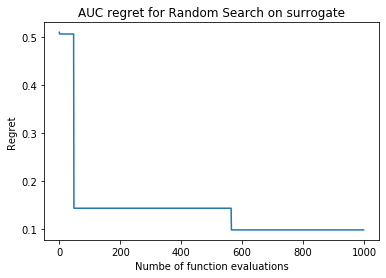

In [8]:
# Sampling random configurations
def random_sample_configurations(num_samples=100):
    colnames = ['cost', 'degree', 'gamma', 'kernel']
    ranges = [(0.000986, 998.492437),
              (2.0, 5.0),
              (0.000988, 913.373845),
              (['linear', 'polynomial', 'radial', 'sigmoid'])]
    X = pd.DataFrame(np.nan, index=range(num_samples), columns=colnames)
    for i in range(len(colnames)):
        if len(ranges[i]) == 2:
            col_val = np.random.uniform(low=ranges[i][0], high=ranges[i][1], size=num_samples)
        else:
            col_val = np.random.choice(ranges[i], size=num_samples)
        X.iloc[:, i] = col_val
    return X


configs = random_sample_configurations(num_samples=1000)
print(configs)

#############################################################################
preds = model.predict(configs)

# tracking the maximum AUC obtained over the functions evaluations
preds = np.maximum.accumulate(preds)
# computing regret (1 - predicted_auc)
regret = 1 - preds

# plotting the regret curve
plt.plot(regret)
plt.title('AUC regret for Random Search on surrogate')
plt.xlabel('Numbe of function evaluations')
plt.ylabel('Regret')


---
Code in this notebook is in large part taken from openml-python under the BSD-3-Clause license, see `Talks\odsc\LICENSE`.